_For this example we will show a spoofed multi-device run. This would translate directly to the case of multiple GPUs._ 

In [1]:
import os
import multiprocessing

os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count={}".format(
    multiprocessing.cpu_count()
)

In [2]:
import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import diffrax as dfx
import optax
import numpy as np 
import matplotlib.pyplot as plt
from chainconsumer import Chain, ChainConsumer
import tensorflow_probability.substrates.jax.distributions as tfd

from configs import make_dirs

from sbiax.utils import make_df, get_shardings
from sbiax.ndes import Ensemble, MAF, CNF, Scaler
from sbiax.train import train_ensemble
from sbiax.inference import nuts_sample

Here we run a toy density-estimation SBI experiment.

Our datavector is made from a Gaussian distributed vector of measurments given a mean $\mu$ and variance $\sigma^2$.

In [3]:
key = jr.key(0)

key, model_key, train_key, sample_key, data_key = jr.split(key, 5)

In [4]:
results_dir = "results/nle/toy/0/"

make_dirs(results_dir)

RESULTS_DIR:
 results/nle/toy/0/


Here we sample a set of $n_s$ simulations from the true data likelihood $\mathcal{G}[\hat{\xi}|\mu, \mathbb{I}\sigma^2]$ for training the normalising flow models. 

To use your own simulations you would replace the code in the next two cells.

In [5]:
n_sims = 10_000
data_dim = 100
parameter_dim = 2

alpha = jnp.array([0.5, 0.5]) # True values of mu and sigma
lower = jnp.array([0., 0.1])
upper = jnp.array([1., 1.])
parameter_names = [r"$\mu$", r"$\sigma$"]

parameter_prior = tfd.Blockwise(
    [tfd.Uniform(lower[0], upper[0]), tfd.Uniform(lower[1], upper[1])]
)

In [6]:
def simulator(key, mu, sigma):
    # Draw data d ~ G[d|mu, I * sigma]
    return jr.multivariate_normal(key, jnp.ones(data_dim) * mu, jnp.eye(data_dim) * sigma)

key_data, key_sims, key_prior = jr.split(data_key, 3)

d = simulator(key_data, alpha[0], alpha[1])

Y = parameter_prior.sample((n_sims,), seed=key_prior)

keys = jr.split(key_sims, n_sims)
D = jax.vmap(simulator)(keys, Y[:, 0], Y[:, 1])

For this experiment we will show an example usage of multiple devices.

We need two shardings: one for the batched data (`sharding`) and one to replicate the models across each device (`replicated sharding`, for each sharded batch).

In [7]:
sharding, replicated_sharding = get_shardings()

Running on 10 local devices: 
	[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6), CpuDevice(id=7), CpuDevice(id=8), CpuDevice(id=9)]


Here we will use a neural network to compress our simulations, by estimating the parameters directly.

In [8]:
from sbiax.compression.nn import fit_nn

net_key, net_train_key = jr.split(key)

net = eqx.nn.MLP(
    D.shape[-1], 
    Y.shape[-1], 
    width_size=32, 
    depth=2, 
    activation=jax.nn.tanh,
    key=net_key
)

opt = optax.adamw(1e-3)

preprocess_fn = lambda x: (x - D.mean(axis=0)) / D.std(axis=0)

model, losses = fit_nn(
    net_train_key, 
    net, 
    train_data=(preprocess_fn(D), Y), 
    opt=opt, 
    n_batch=500, 
    patience=1000,
    sharding=sharding,
    replicated_sharding=replicated_sharding
)

X = jax.vmap(model)(preprocess_fn(D))

X_ = model(preprocess_fn(d)) # Our mock datavector

Training NN:   0%|          | 0/10000 [00:00<?, ?it/s]

Next we build the density-estimating normalising flows, which will be used for Neural Likelihood Estimation (NLE).

We'll use two masked autoregressive flows (MAFs, Papamakarios++2017) and put them in an `Ensemble`. This object can pass through `jit` boundaries and has its own `log_prob` functions.

In [9]:
model_keys = jr.split(model_key, 2)

sbi_type = "nle"

scaler = Scaler(X, Y, use_scaling=True)

solver = dfx.Heun()

ndes = [
    MAF(
        event_dim=alpha.size, 
        context_dim=alpha.size, 
        width_size=32,
        nn_depth=2,
        n_layers=5,
        scaler=scaler,
        key=model_keys[0]
    ),
    CNF(
        event_dim=alpha.size, 
        context_dim=alpha.size, 
        solver=solver,
        dt=0.1,
        t1=1.0,
        width_size=8,
        depth=0,
        activation=jax.nn.tanh,
        scaler=scaler,
        key=model_keys[1]
    ) 
]

ensemble = Ensemble(ndes, sbi_type=sbi_type)

Now we fit the flow ensemble to the compressed simulations $\{ (\hat{\pi}, \pi)_0, ..., (\hat{\pi}, \pi)_N\}$

In [10]:
opt = optax.adamw(1e-3)

ensemble, stats = train_ensemble(
    train_key, 
    ensemble,
    train_mode=sbi_type,
    train_data=(X, Y), 
    opt=opt,
    n_batch=50,
    patience=20,
    n_epochs=1_000,
    sharding=sharding,
    replicated_sharding=replicated_sharding,
    results_dir=results_dir
)

NDE has n_params=13173.


Training:   0%|          | 0/1000 [00:00<?, ?epoch/s]

NDE has n_params=28.


Training:   0%|          | 0/1000 [00:00<?, ?epoch/s]

Weights: [0.5224523  0.47754768]


Now we sample a measurement to condition our posterior with. This noisy datavector is from the same likelihood above, and we pass it to the `Ensemble` likelihood function.

This `log_prob` function is sampled via the `nuts_sample` function below. It is conditioned on our datavector `X_` we 'measured' above.

In [11]:
# Get a noisy datavector with different alpha parameters
key_data, key_state, key_sample = jr.split(sample_key, 3)

In [12]:
ensemble = eqx.nn.inference_mode(ensemble)

log_prob_fn = ensemble.ensemble_log_prob_fn(X_, parameter_prior)

In [13]:
n_chains = 3 # Sample multiple chains for this posterior

samples, samples_log_prob = nuts_sample(
    key_sample, 
    log_prob_fn, 
    n_chains=n_chains, 
    prior=parameter_prior
)

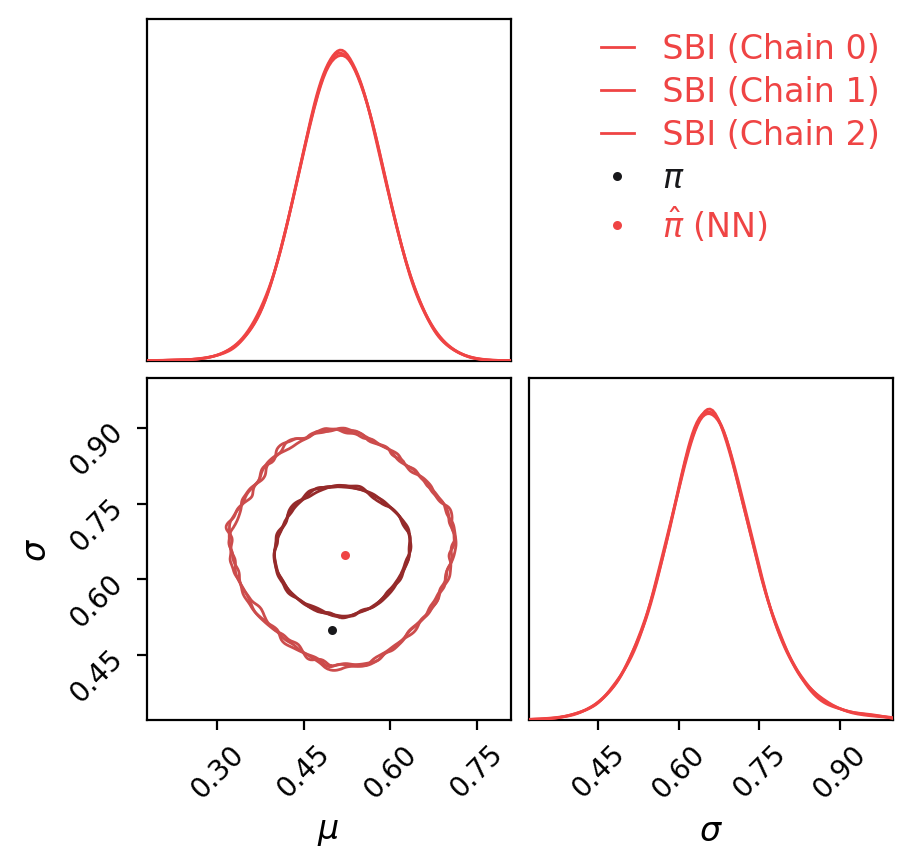

In [14]:
c = ChainConsumer()

for n in range(n_chains):
    c.add_chain(
        Chain(
            samples=make_df(samples[n], samples_log_prob[n], parameter_names), 
            name="SBI (Chain {})".format(n),
            color="r", 
            shade_alpha=0.
        )
    )

c.add_marker(
    location=dict(zip(parameter_names, np.asarray(alpha))), name=r"$\pi$", color="k"
)
c.add_marker(
    location=dict(zip(parameter_names, np.asarray(X_))), name=r"$\hat{\pi}$ (NN)", color="r"
)

fig = c.plotter.plot()
fig.set_dpi(200)
fig.set_figheight(4.5)
fig.set_figwidth(4.5)
plt.show()

We can sample the posterior for each flow, one at a time.

This is done by using the `nde_log_prob_fn` of the `Ensemble` module.

In [15]:
n_chains = 1

posteriors = []
for nde in ensemble.ndes:
    log_prob_fn = ensemble.nde_log_prob_fn(nde, X_, parameter_prior)

    nde_posterior = nuts_sample(
        key_sample, log_prob_fn, n_chains=n_chains, prior=parameter_prior
    )
    posteriors.append(nde_posterior)

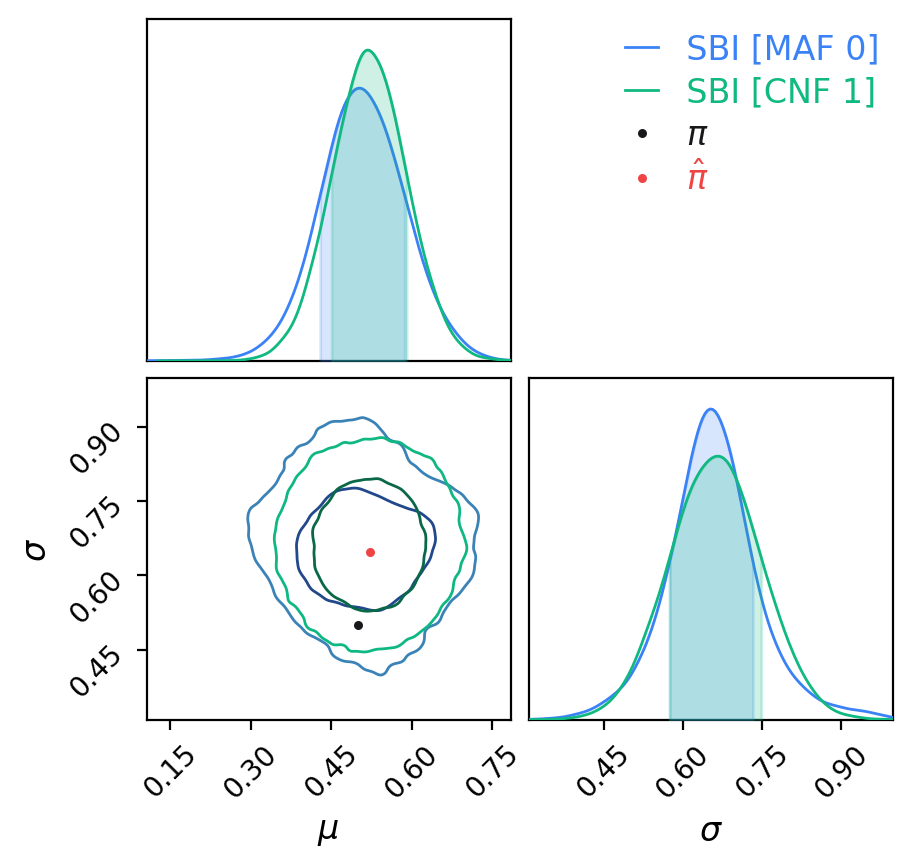

In [16]:
c = ChainConsumer()

for i, posterior in enumerate(posteriors):
    samples, samples_log_prob = posterior
    for n in range(n_chains):
        c.add_chain(
            Chain(
                samples=make_df(samples[n], samples_log_prob[n], parameter_names), 
                name="SBI [{} {}]".format(ensemble.get_nde_names()[i], i), 
                shade_alpha=0.
            )
        )

c.add_marker(
    location=dict(zip(parameter_names, np.asarray(alpha))), name=r"$\pi$", color="k"
)
c.add_marker(
    location=dict(zip(parameter_names, np.asarray(X_))), name=r"$\hat{\pi}$", color="r"
)

fig = c.plotter.plot()
fig.set_dpi(200)
fig.set_figheight(4.5)
fig.set_figwidth(4.5)
plt.show()

Have a look at the other examples.